In [2]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [17]:
player_data = download.file("https://github.com/apepers/DSCI-100-Project/raw/refs/heads/main/players.csv", "players.csv")
session_data = download.file("https://github.com/apepers/DSCI-100-Project/raw/refs/heads/main/sessions.csv", "sessions.csv")

players = read_csv("players.csv")
sessions = read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Summary of Dataset

Code for calculating these stats can be found at the end of the report, <a href="#Calculations">here.</a>

#### Players Dataset
This dataset contains 196 observations of players registered by the PLAICraft team, with 9 variables:

| Variable Name | Type | Meaning | Summary Stat |
| ------------- | ---- | ------- | ------------ |
| experience    | chr |Category of familiarity with Minecraft, with 5 options |  |
| subscribe     | lgl  | True if player is subscribed to mailing list, False if not | 144 True/52 False (73.47% True) |
| hashedEmail   | chr  | Player email, hashed for privacy | |
| played_hours  | dbl  | Hours played  | Min: 0<br>Max: 223.1 <br>Mean: 5.85|
| name          | chr  | Identifying name of player | |
| gender        | chr  | Gender disclosed by player (including choice to opt-out) |  |
| Age           | dbl  | Age of player | Min: 9<br> Max: 58 <br> Mean: 21.14 |

hashedEmail and name both have 0 repeated values, so both could function as identifiers, but we'll see in the second database that hashedEmail is the shared identifier across both sets. We aren't given information on whether the name field might be a username with enforced unique requirements, or a generated name meant to anonymize the participant data, but given the hashedEmail identifier we won't need to use the name field for any investigations.

The dataset is already tidy and NAs are only present in the Age variable, which has 2. Gender should be treated as a factor, as we see all responses fit into 7 options (which we visualize later in this report.) 

Experience could be treated as a factor with 5 options, but also implies an increasing amount of experience that could be represented numerically (ie, Beginner = 1, Amateur = 1, etc) with the downside of not being sure what scale the researchers actually presented (ie, is Pro a higher or lower level of experience than Veteran?)

#### Sessions Dataset
This dataset contains 1535 observations of individual play sessions recorded by the PLAICraft team, with 5 variables:
| Variable Name       | Type | Meaning | Summary Stat |
| ------------------- | ---- | ------- | ------------ |
| hashedEmail         | chr  | Player email, hashed for privacy |  |
| start_time          | chr  | Start of session in day/month/year and 24 hr format | (All calculated by converting to datetime)<br>Min : 2024-04-06 09:27:00 |
| end_time            | chr  | End of session in same format as start_time | (All calculated by converting to datetime)<br> Max: 2024-09-26 07:39:00 <br> Mean duration between start_time and end_time: 50.86 mins|
| original_start_time | dbl  | Lower precision session start time, expressed in milliseconds from Unix Epoch | |
| original_end_time   | dbl  | Lower precision session end time, in same format as original_start_time |  |

While the original_start_time and original_end_time are numerical variables, they represent Unix Epoch time and calculating summary statistics like mean doesn't make sense. I've included the minimum for start_time and maximum for end_time as this tells us that data was collected between April 6th and Sept 26th, 2024. The start_time and end_time are provided as character type, but should be converted to datetime.

The reason for start and end time being included twice, once in date time format and once in Unix Epoch millisecond time, is unclear. When compaired, they also don't exactly match, and in some cases original_start_time and original_end_time are the same number. In those situations the start_time and end_time show a session of short duration, and so my theory is that some precision has been lost with these millisecond Unix Epoch times, which is why they don't match precisely. Since the start_time and end_time are more detailed and don't match each other, those are the fields I would use if my question related to session information.

hashedEmails acts as the identifier and can be matched with the data in the players dataset. Grouping by unique showed that there are 125 unique hashed emails in the set, with the mean number of repeat sessions being 12.28. This is notable since it's lower than the 196 entries in the players dataset, but as we will see in visualization, a significant number of entries in the players dataset have 0 played hours and so would not be present in the sessions dataset.

The only NAs present in the set are from two observations that have NA in both end_time and original_end_time. The start times of these two observations are different, so it's not clear why these two observations are missing end times.

### Question of Interest

Broad question: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

Specific: Can the age and experience of a player be used to predict the sum total of hours played across multiple sessions of PLAICraft?

Since the research team is looking for 'kinds' of players, we include Age as demographic information. I decided against including gender because the data is lacking in many observations for most genders, and so we don't have sufficient training data to use it as a predictor. Experience is the one additional detail for 'type' of player, and I plan to convert it from 5 discrete factors into a linear scale of 1-5 in the order Amateur, Beginner, Regular, Veteran, and Pro.

The researchers are asking to identify predictors for players who contribute a "large amount" of data which could be considered categorical, but I plan to treat it as a regression problem where we predict the numerical value of played_hours for a given type of player. This gives the researchers the ability to define their own cutoff for what minimum number of hours is considered 'large'.

### Exploratory Data Analysis and Visualization

#### Age and played_time

[1] "Players with 0 hours:  85"


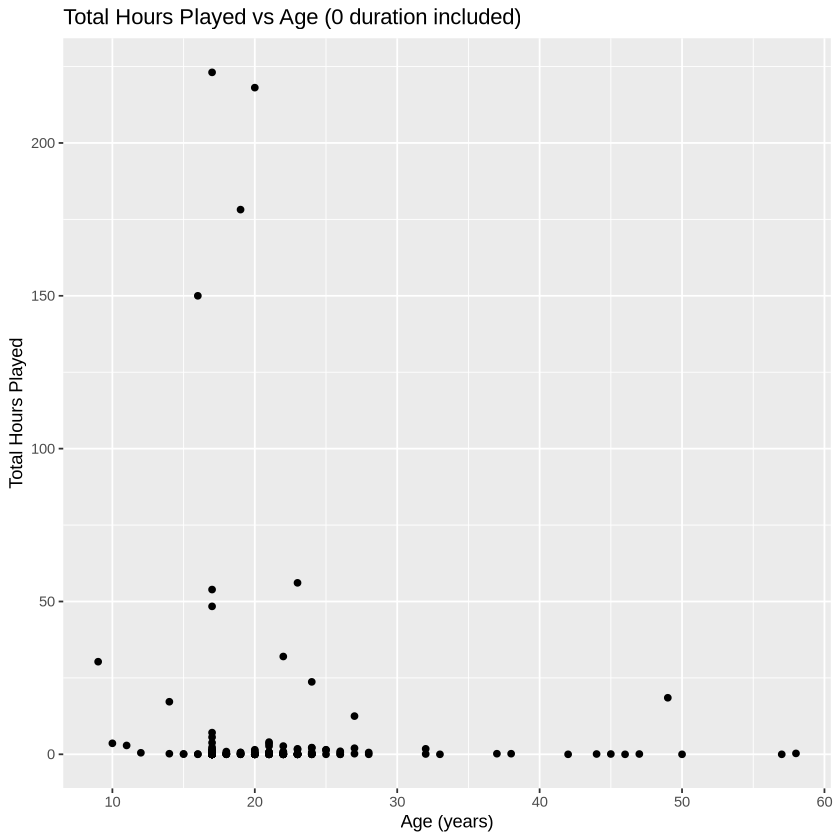

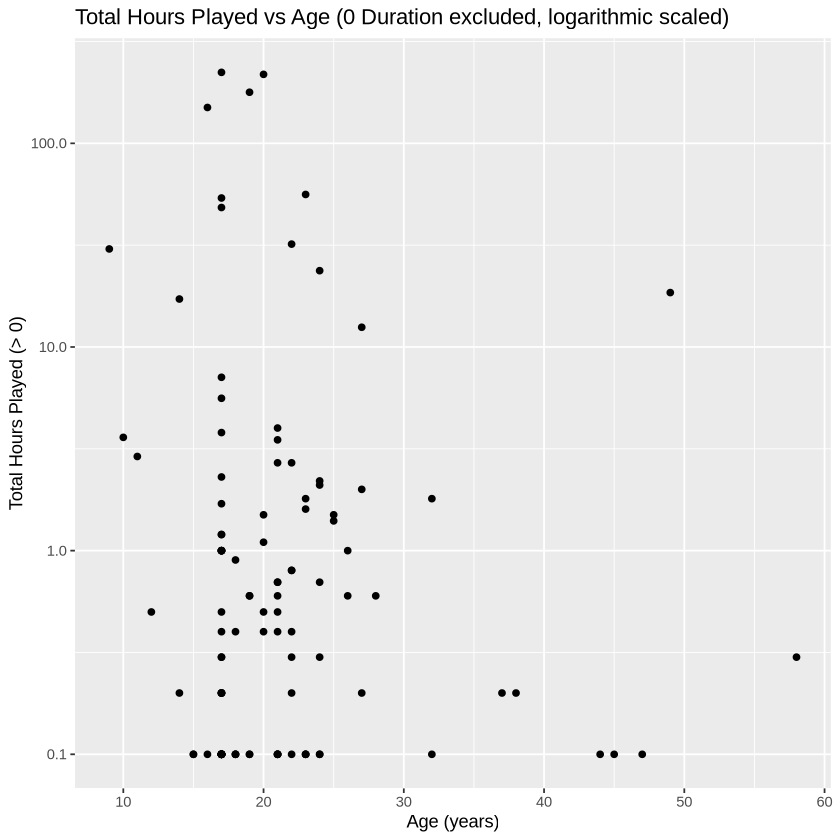

In [24]:
age_time_plot = players |>
    ggplot(aes(x = Age, y = played_hours)) +
    geom_point(na.rm = TRUE) +
    labs(x = "Age (years)", y = "Total Hours Played") +
    ggtitle("Total Hours Played vs Age (0 duration included)")

age_time_plot

zero_hour_count = players |>
    filter(played_hours == 0) |>
    summarize(n = n()) |>
    pull()
print(paste("Players with 0 hours: ", zero_hour_count))

age_time_plot_no_0 = players |>
    filter(played_hours > 0) |>
    ggplot(aes(x = Age, y = played_hours)) +
    geom_point(na.rm = TRUE) +
    labs(x = "Age (years)", y = "Total Hours Played (> 0)") +
    ggtitle("Total Hours Played vs Age (0 Duration excluded, logarithmic scaled)") +
    scale_y_log10()

age_time_plot_no_0

Visualizing the relationship between age and played hours gives us our first demonstration of a challenge with the data. 85 players (43%) have 0 played hours listed, and there are also 4 outlier players who logged over 100 hours. To visualize the full range of values we need a logarithmic y-axis, which requires values > 0. The logarithmic views shows us that most players are near the mean age of 21, and played less than the mean of 5 played hours. From this visualization, there doesn't seem to be a clear relationship.

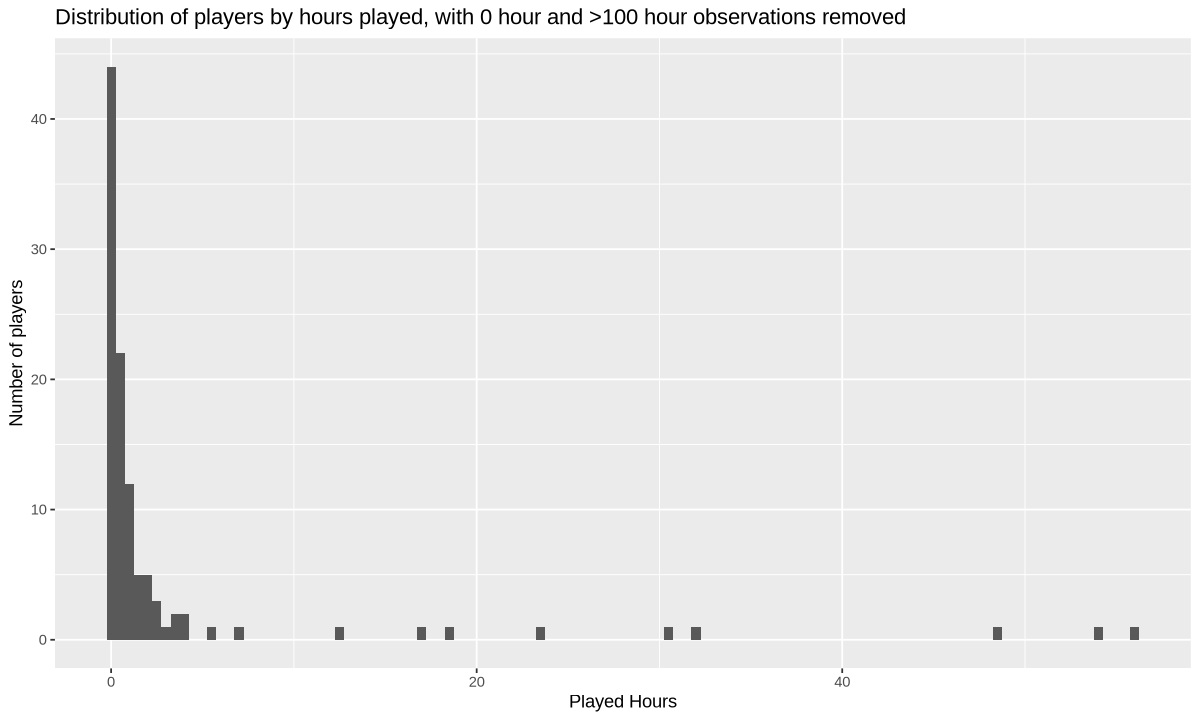

In [36]:
options(repr.plot.height = 6, repr.plot.width = 10)

played_hours_histogram = players |>
    filter(played_hours > 0) |>
    filter(played_hours < 100) |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(binwidth = 0.5) +
    labs(x = "Played Hours", y = "Number of players") +
    ggtitle("Distribution of players by hours played, with 0 hour and >100 hour observations removed")

played_hours_histogram

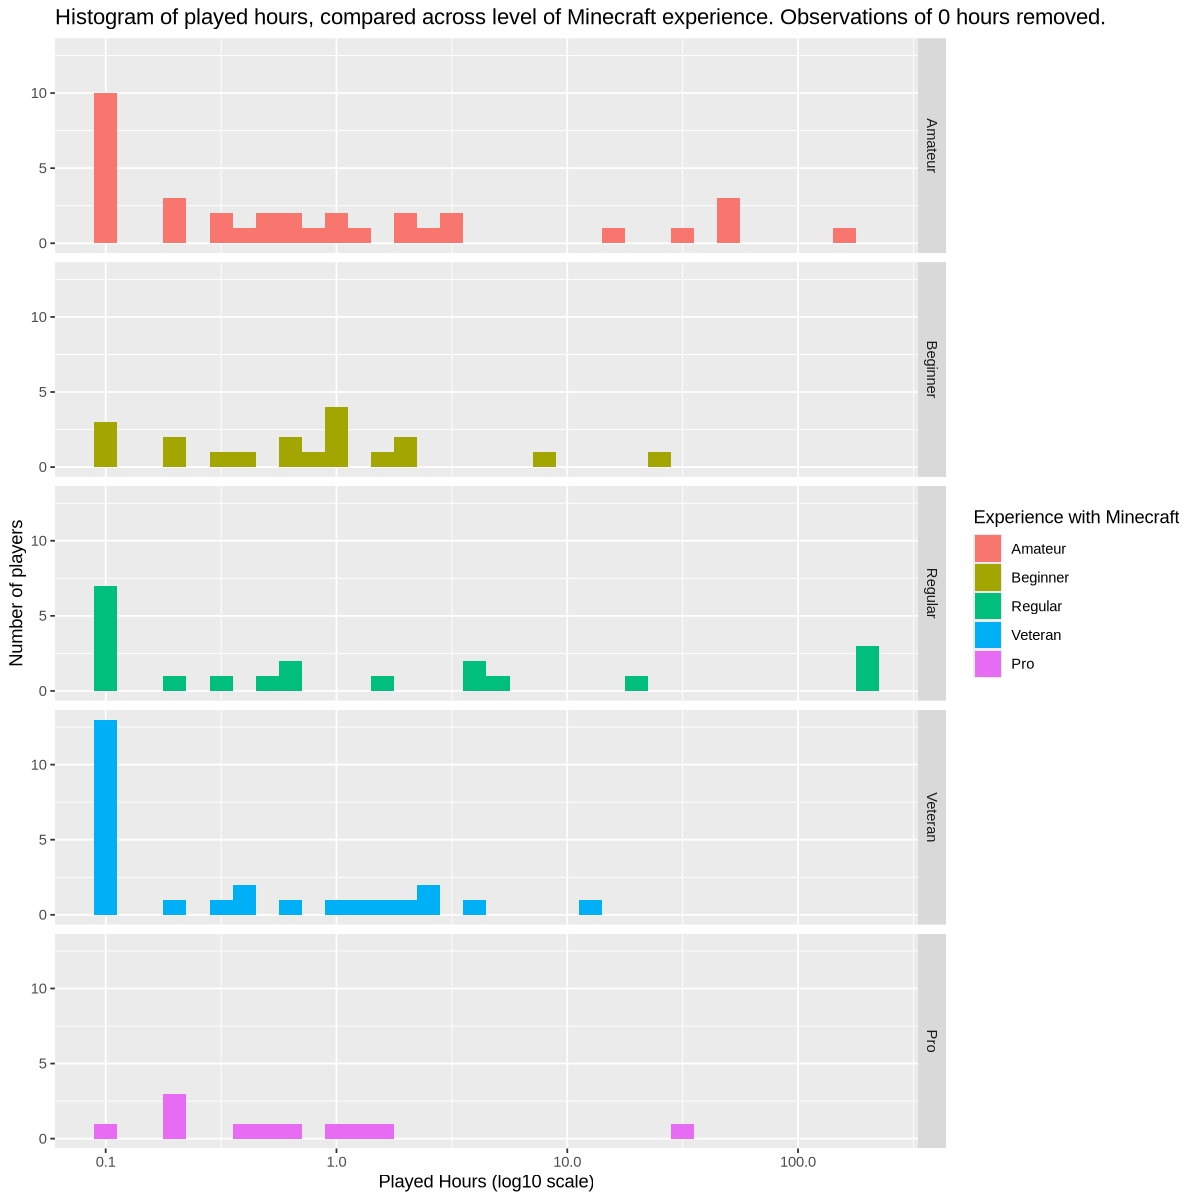

In [49]:
options(repr.plot.height = 10, repr.plot.width = 10)

experience_hours_histogram = players |>
    mutate(experience = factor(experience, c("Amateur", "Beginner", "Regular", "Veteran", "Pro"))) |>
    filter(played_hours > 0) |>
    ggplot(aes(x = played_hours, fill = experience)) +
    geom_histogram(binwidth = 0.1) +
    scale_x_log10() +
    labs(x = "Played Hours (log10 scale)", y = "Number of players", fill = "Experience with Minecraft") +
    ggtitle("Histogram of played hours, compared across level of Minecraft experience. Observations of 0 hours removed.") +
    facet_grid(rows = vars(experience))

experience_hours_histogram

Comparing histograms of played hours for different experience levels is more promising, where it seems like less experienced players may have played more, suggesting a weak negative relationship between played_hours and experience.

### Methods and Plan

My plan is to use K nearest neighbour regression using Age and experience as predictor variables and played_hours as the responsible variable. The relationship between these variables doesn't seem linear and so I'm choosing K nearest neighbour for its flexibility modelling non-linear relationships. One downside is that if the researchers do succeed in collecting a much larger dataset, this method will become slow.

Breaking down the process for doing the regression:
- Split the data into training and testing, with a 75/25 split
- Scale and center both predictors, creating a recipe
- Create a model where the number of neighbors K is a tuning value
- 5-fold cross-validation using vfold_cv, on the training data. This will give me 5 splits of the data that I can use to figure out my best choice of K.
- Use a tune_grid to run through the cross-validation for K = 1 to 100. (100 is chosen since there'll be 147 entries in the training data, and then just over 100 after the vfold, so a K of 100 covers all the way to the extreme of counting most other points as neighbours. I expect the best K to be much lower.)
- Look at the RMSE from the tune_grid results and pick the K associated with the lowest RMSE
- Set up another model that uses this best K value, and fit it to the full training data set.
- Finally, run prediction on the testing data set and report the RMSPE to get a sense of how good the model is.

### Calculations

In [18]:
subscribe_split = players |>
    group_by(as_factor(subscribe)) |>
    summarize(n = n())

print("Split for 'subscribe' variable:")
subscribe_split

print("Summary stats for played_hours variable:")
played_hour_stats = players |>
    summarize(mean = mean(played_hours, na.rm = TRUE), min = min(played_hours, na.rm = TRUE), max = max(played_hours, na.rm = TRUE))

played_hour_stats

print("Summary stats for Age variable:")
age_stats = players |>
    summarize(mean = mean(Age, na.rm = TRUE), min = min(Age, na.rm = TRUE), max = max(Age, na.rm = TRUE))

age_stats

# Source for figuring out how to use is.na across all columns like this: https://stackoverflow.com/questions/26273663/r-how-to-total-the-number-of-na-in-each-col-of-data-frame
na_player_counts = players |>
    summarise(across(everything(), ~ sum(is.na(.x))))

print("NA counts:")
na_player_counts

[1] "Split for 'subscribe' variable:"


as_factor(subscribe),n
<fct>,<int>
FALSE,52
TRUE,144


[1] "Summary stats for played_hours variable:"


mean,min,max
<dbl>,<dbl>,<dbl>
5.845918,0,223.1


[1] "Summary stats for Age variable:"


mean,min,max
<dbl>,<dbl>,<dbl>
21.13918,9,58


[1] "NA counts:"


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,2


In [50]:
# TODO - code for the sessions dataset